# 1. Loading Data and Libraries

In [1]:
# load necessary libraries
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Setup Google Cloud BigQuery API

# Set file path key
key_path = "/Users/theodoreleeiv/Documents/Documents - Theodore’s MacBook Pro/Google Cloud/inbound-density-428819-p8-aef577a5f38e.json"
credentials = service_account.Credentials.from_service_account_file(key_path)
client = bigquery.Client()

def QUERY(query):
    """
    Queries BigQuery
    :param query: string
    :return: dataframe
    """
    query = str(query)
    query_job = client.query(query)
    return query_job.result().to_dataframe()


## General Readmission Stats

In [3]:
# 1. Is there a difference in readmission rates between patients diagnosed with a mental health disorders and those with non-mental health related disorders?
avg_admission_rate = QUERY("""
  SELECT
    CASE
    WHEN is_mh_disorder = 0 THEN 'Non-MH-Diagnosis'
    ELSE 'MH-Disorder'
  END AS is_mh_disorder,
  AVG(days_to_readmission) AS avg_readmissions,
  SUM(had_readmission_within_30) AS total_readmissions,
  ROUND((SUM(had_readmission_within_30)/COUNT(*))*100,2) AS percent_total_readmissions

FROM
  `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r

LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS p

ON r.subject_id = p.subject_id

LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d
ON
  r.stay_id = d.stay_id
GROUP BY is_mh_disorder



ORDER BY total_readmissions DESC
""")


In [4]:
avg_admission_rate

,is_mh_disorder,avg_readmissions,total_readmissions,percent_total_readmissions
0,Non-MH-Diagnosis,14.314654,318332,23.16
1,MH-Disorder,14.200670,54329,50.24


Approximately 50% of emergency department admissions for mental health issues were readmissions, compared to only about 23% for non-mental health-related admissions.

In [ ]:
# Set a Clean white style for plots
sns.set_style("white")
# Set default palette color to red purple
sns.set_palette('RdPu')

## Age and Mental Health Diagnosis

In [6]:
# 1. What age group has the highest readmission rate?
group_with_highest_readmission = QUERY("""
    SELECT
      p.age_group,
      AVG(r.days_to_readmission) AS avg_num_of_days_to_readmission,
      SUM(r.had_readmission_within_30)AS total_num_of_readmissions,
      ROUND((SUM(r.had_readmission_within_30)/COUNT(*)) * 100,2) AS percent_of_readmissions
    FROM
      `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS p
    LEFT JOIN
      `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r
    ON
      r.subject_id = p.subject_id
    LEFT JOIN
      `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d
    ON
        r.stay_id = d.stay_id
    WHERE d.is_mh_disorder = 1
    GROUP BY p.age_group
    ORDER BY total_num_of_readmissions DESC
""")

In [9]:
group_with_highest_readmission = group_with_highest_readmission.sort_values(by='percent_of_readmissions',ascending=False).dropna()

/var/folders/dl/r49548rn2gzfpg1c87vrjnvw0000gn/T/ipykernel_11628/3250280601.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


Text(0, 0.5, 'Proportion of Readmissions')

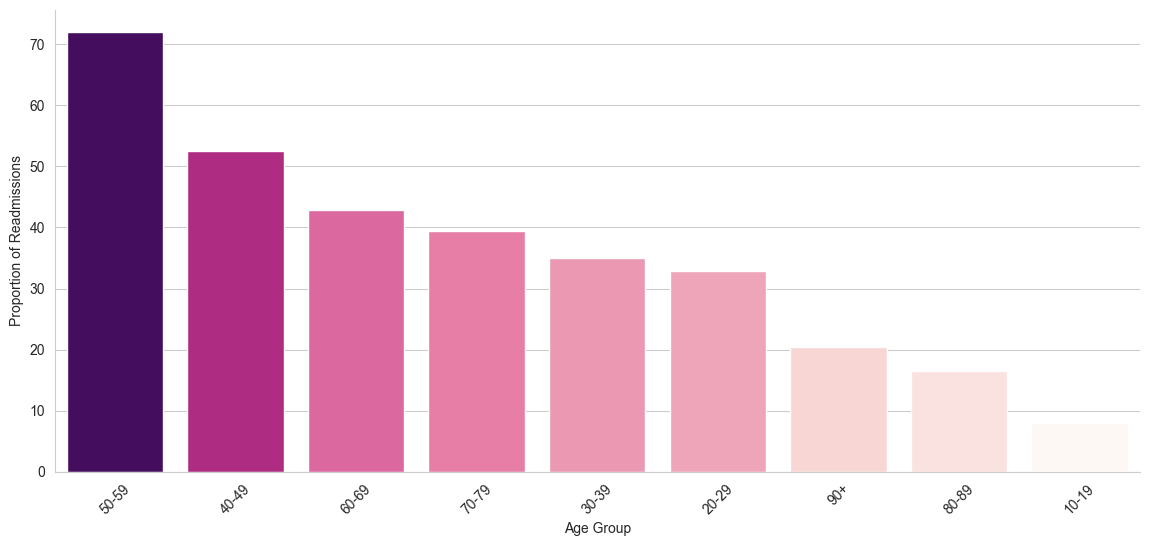

In [10]:
fig,ax1 = plt.subplots(nrows=1,ncols=1,figsize=(14,6))
sns.barplot(x="age_group", y="percent_of_readmissions",estimator='mean',hue ="percent_of_readmissions",palette='RdPu',data=group_with_highest_readmission,ax=ax1)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.legend().set_visible(False)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax1.set_xlabel("Age Group")
ax1.set_ylabel("Proportion of Readmissions")

The two highest age groups with the highest proportion of readmissions were those aged 50-59 and 40-59, with proportions of readmissions that were about 72% and 53%, respectively. These groups have significantly different proportions compared to other groups. I would have expected the data to demonstrate that the older you get the more readmissions you would have since older people are likely to have greater health complications overtime. However, it seems that the data here tells a mixed story. Mostly, older individuals have a greater proportion of readmissions except those 80 and up. Perhaps those 80 and up deal with different mental health issues that may not be as chronic or severe as those in there 40s - 70s.

In [11]:
#1.1 What are the readmission rates by age group and diagnosis?

age_groups_by_diagnosis = QUERY("""
SELECT
  p.age_group,
  d.mental_health_category,
  SUM(r.had_readmission_within_30) AS total_num_of_readmissions,
  ROUND((SUM(r.had_readmission_within_30)/COUNT(*)) * 100, 2) AS percent_of_readmissions
FROM
  `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS p
LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r
ON
  r.subject_id = p.subject_id
LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d
ON
  r.stay_id = d.stay_id
WHERE d.is_mh_disorder = 1
GROUP BY
  p.age_group, d.mental_health_category
HAVING
  total_num_of_readmissions > 1
ORDER BY
  percent_of_readmissions DESC
""")

In [12]:
age_groups_by_diagnosis = age_groups_by_diagnosis.pivot_table(index='age_group', columns='mental_health_category',values='percent_of_readmissions')

Text(0.5, 1.0, 'Percent of Readmissions by Age Group and Mental Health Diagnosis')

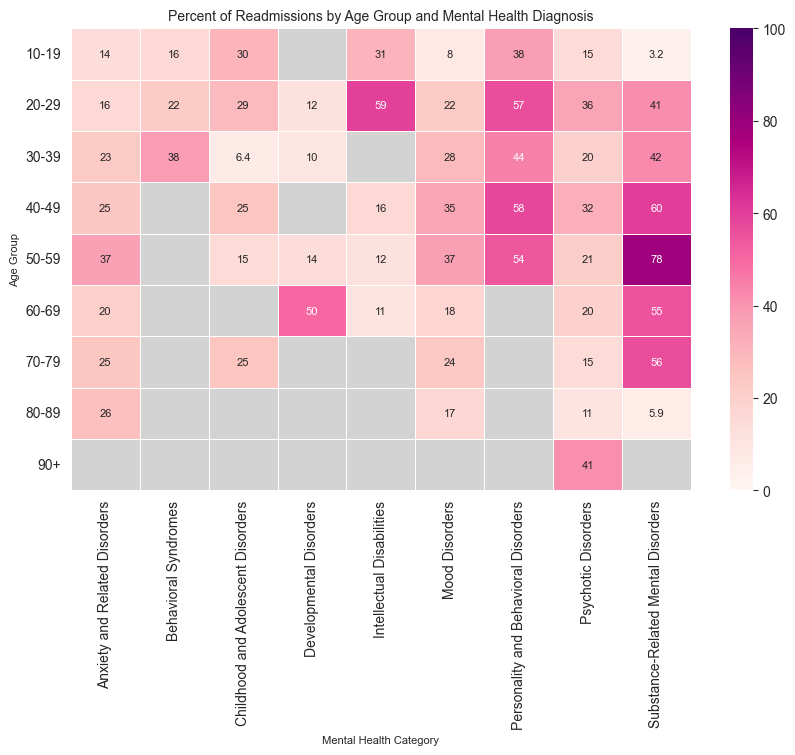

In [21]:
# Create a mask for NaN values
mask = age_groups_by_diagnosis.isnull()

# Create a custom colormap where NaNs appear gray
cmap = sns.color_palette("RdPu", as_cmap=True)
cmap.set_bad(color='lightgray')  # Set NaNs to light gray
fig,ax = plt.subplots(figsize=(10,6))
# Plot the heatmap
sns.heatmap(age_groups_by_diagnosis, mask=mask, cmap=cmap, linewidths=0.5,ax=ax,annot=True,annot_kws=({'size':8}),vmin=0,vmax=100)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_title('')
ax.set_ylabel('Age Group', fontsize=8)
ax.set_xlabel('Mental Health Category', fontsize=8)
ax.set_title("Percent of Readmissions by Age Group and Mental Health Diagnosis", fontsize=10)

Overall, substance‑related disorders and personality disorders show the highest readmission rates across all age groups, suggesting these patients may be at particularly elevated risk. Notably, individuals in their 50s with a substance‑related diagnosis have a 78% readmission rate—far exceeding any other age‑diagnosis combination.

**Age‑specific highlights:**

**20s**: Among patients in their 20s, those diagnosed with intellectual disabilities exhibit the highest readmission rate compared to other diagnostic categories in this cohort.

**50s**: As noted, substance‑related disorders peak in this decade at 78%, underscoring the vulnerability of middle‑aged patients with these conditions.

**60s**: In patients aged 60, developmental disorders carry the highest readmission rate (50%), indicating a distinct risk pattern in later life.

**90s+**: In patients 90 and older, psychotic disorders have the highest readmission rate (41%), demonstrating that there is a higher risk for these patients as they get much older

These patterns suggest targeted interventions—particularly for substance‑related, personality, intellectual disability, developmental, and psychotic disorders, populations—could help reduce ED bounce‑backs in the highest‑risk age groups. After reviewing this chart, it becomes clearer as to why those in their 80s and up much lower overall readmission rate compared to those in their 40s and 70s. Patients in their 80s and up, for the most part, tend to suffer from less severe mental health disorders. For example, Anxiety Related Disorders amongst all groups still have a lower readmission rate than the overall readmission rate and these patients only have 5.9% readmission rate for Substance Related Mental Health Disorders. While those in their 90s tend to suffer from Psychotic Disorders, this is the only mental ailment these individuals seem to suffer from still with a lower readmission rate than the overall readmission rate for those diagnosed with any mental health diagnosis. 

In [14]:
# 1.2 What age group on average has the highest number of comorbities per patient?
age_groups_by_comorbities = QUERY("""
SELECT
    age_group,
    ROUND(avg(num_comorbities),1) AS avg_num_comorbitites
FROM
    (SELECT
      p.age_group,
      p.subject_id,
      Count(icd_code) AS num_comorbities
      
    FROM
      `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS p
    LEFT JOIN
      `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r
    ON
      r.subject_id = p.subject_id
    LEFT JOIN
      `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d
    ON
      r.stay_id = d.stay_id
    WHERE d.seq_num > 1 AND d.is_mh_disorder = 1
    GROUP BY
      p.age_group,
      p.subject_id
        
    ORDER BY
      num_comorbities DESC) AS patient_counts
GROUP BY
  age_group
ORDER BY
  age_group;
  
""")

In [18]:
age_groups_by_comorbities

,age_group,avg_num_comorbitites
0,10-19,1.5
1,20-29,2.5
2,30-39,3.2
3,40-49,5.6
4,50-59,8.9
5,60-69,3.2
6,70-79,2.7
7,80-89,1.7
8,90+,1.3
9,Unknown,1.3


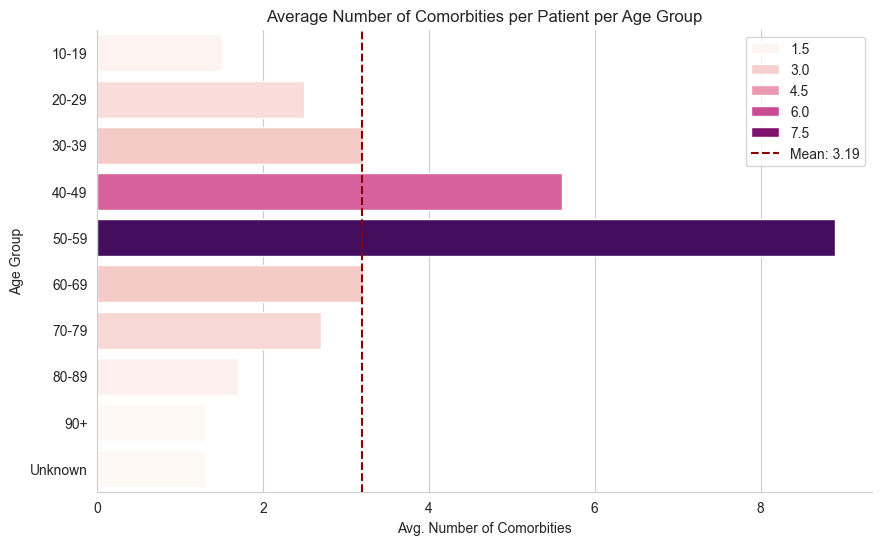

In [24]:
# plot a horizzontal bar chart of the number of comorbities by age_group
fig,ax = plt.subplots(figsize=(10,6))
sns.barplot(data=age_groups_by_comorbities, x="avg_num_comorbitites", y="age_group",orient='h',hue="avg_num_comorbitites",palette='RdPu',ax=ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Age Group')
ax.set_xlabel('Avg. Number of Comorbities')
ax.set_title('Average Number of Comorbities per Patient per Age Group')
ax.legend()

# add a line to indicate the overall average of comorbitites per patient
com_mean_value = age_groups_by_comorbities['avg_num_comorbitites'].mean() # Get the overall mean of number of comorbities by age_group
ax.axvline(com_mean_value, color='darkred', linestyle='--', linewidth=1.5, label=f'Mean: {com_mean_value:.2f}')
ax.legend()

Patients between the ages of 40 - 59, have a higher amount of comorbities on average per patient compared to other age groups and that is well above the overall mean indicating that patients in these age groups may suffer from more complex diagnosis and require more targeted intervention. We have already found that individuals in these age groups have a high readmission rate for Substance Related Mental Health Disorders so it makes sense why they would have a high average comorbitiy. Substance Related Mental Health disorders are typically accompanied with other mental health disorders due to various changes to neural pathways, social changes, relationship changes, and more.

## Gender and Mental Health Diagnosis

In [37]:
# 1.What gender has the highest readmission rate? 
gender_by_admission = QUERY("""
    SELECT
  gender,
  AVG(days_to_readmission) AS avg_readmissions,
  SUM(had_readmission_within_30) AS total_readmissions,
  ROUND((SUM(had_readmission_within_30)/COUNT(*))*100,2) AS percent_total_readmissions

FROM
  `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r

LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS p

ON r.subject_id = p.subject_id

LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d
ON
  r.stay_id = d.stay_id
WHERE d.is_mh_disorder = 1



GROUP BY gender
ORDER BY total_readmissions DESC
""")
gender_by_admission

,gender,avg_readmissions,total_readmissions,percent_total_readmissions
0,M,14.167023,47480,59.12
1,F,14.530028,6131,23.76


Male patients have more readmissions compared to Women, 59.12% of male admissions to the emergency department are readmissions. The reason this is currently the case is still unclear but it might be due to the differences in the types of diagnosis male patients have versus female patients.

In [4]:
# 1.1 What are the top 10 diagnosis category by gender?
top_10_mh_cat_diagnosis_by_gender = QUERY("""
  SELECT
  gender,
  mental_health_category,
  AVG(days_to_readmission) AS avg_readmissions,
  SUM(had_readmission_within_30) AS total_readmissions,
  ROUND((SUM(had_readmission_within_30)/COUNT(*))*100,2) AS percent_total_readmissions


FROM
  `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r

LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS p

ON r.subject_id = p.subject_id
LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d

ON r.stay_id = d.stay_id
WHERE d.is_mh_disorder = 1


GROUP BY gender,mental_health_category
ORDER BY gender DESC, percent_total_readmissions DESC
""")

In [5]:
top_10_mh_cat_diagnosis_by_gender

,gender,mental_health_category,avg_readmissions,total_readmissions,percent_total_readmissions
0,M,Substance-Related Mental Disorders,14.115054,41759,66.75
1,M,Personality and Behavioral Disorders,14.341014,181,52.77
2,M,Mood Disorders,14.797210,3400,33.90
3,M,Psychotic Disorders,14.473930,1269,33.02
4,M,Intellectual Disabilities,18.112903,47,29.56
5,M,Anxiety and Related Disorders,13.243876,754,25.36
6,M,Childhood and Adolescent Disorders,14.512500,56,22.05
7,M,Behavioral Syndromes,20.571429,8,12.90
8,M,Developmental Disorders,12.571429,6,7.14
9,M,Unspecified Mental Disorders,NaN,0,0.00


Among male patients admitted to the emergency department for Substance-Related Mental Health Disorders and Personality and Behavioral Disorders, 67% and 53%, respectively, were readmitted for the same conditions. In contrast, among female patients admitted for these disorders, the pattern is reversed: 55% of those admitted for Personality and Behavioral Disorders were readmissions, compared to 29% for Substance-Related Mental Health Disorders. These two conditions represent the most common reasons for readmission to the emergency department in both male and female patients. So, this gives us more insight why more male patients have higher readmission rates compared to female patients. Substance Related Mental Disorders have the greatest risk for readmissions for Male patients and generally across age groups. 

In [6]:
# 1.2 What are the top 10 icd codes?
top_10_mh_icd_diagnosis_by_gender = QUERY("""
  SELECT
  gender,
  icd_title,
  AVG(days_to_readmission) AS avg_readmissions,
  SUM(had_readmission_within_30) AS total_readmissions,
  ROUND((SUM(had_readmission_within_30)/COUNT(*))*100,2) AS percent_total_readmissions


FROM
  `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r

LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS p

ON r.subject_id = p.subject_id
LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d

ON r.stay_id = d.stay_id
WHERE d.is_mh_disorder = 1


GROUP BY gender,icd_title
ORDER BY gender DESC, total_readmissions DESC
LIMIT 10
""")

In [7]:
top_10_mh_icd_diagnosis_by_gender

,gender,icd_title,avg_readmissions,total_readmissions,percent_total_readmissions
0,M,"Alcohol abuse with intoxication, unspecified",14.105524,17554,74.64
1,M,ALCOHOL ABUSE-UNSPEC,13.840377,10084,64.20
2,M,"Alcohol dependence with intoxication, unspecified",14.465333,5250,79.10
3,M,AC ALCOHOL INTOX-UNSPEC,14.415229,3020,68.53
4,M,"Major depressive disorder, single episode, uns...",14.574786,1661,38.31
5,M,DEPRESSIVE DISORDER,15.674635,1324,34.63
6,M,AC ALCOHOL INTOX-CONTIN,13.748915,1137,78.36
7,M,ALCOH DEP NEC/NOS-UNSPEC,14.232947,649,44.00
8,M,ALCOHOL WITHDRAWAL,14.812367,426,42.94
9,M,DRUG ABUSE NEC-UNSPEC,14.584245,410,47.56


Diving further into the specific ICD codes within the mental health categories, an analysis of the top 10 mental health diagnoses—ranked by both the number and percentage of readmissions—reinforces our earlier findings. Substance-Related Disorders continue to account for a significant portion of readmissions, along with Personality and Behavioral Disorders, particularly Depressive Disorder and Major Depressive Disorder in this case.

## Race and Mental Health Diagnosis

In [54]:
#1. What are the readmission rates and average length of stay(ALOS) by racial group?
race_group_readmission_rates = QUERY("""
SELECT  
  race_group,
  SUM(had_readmission_within_30) AS total_readmissions,
  ROUND((SUM(had_readmission_within_30)/COUNT(*))*100,2) AS percent_total_readmissions,
  AVG(LOS_hr) AS ALOS
FROM 
  `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r
  
LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS p
ON
r.subject_id = p.subject_id
LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d

ON r.stay_id = d.stay_id
WHERE d.is_mh_disorder = 1
GROUP BY race_group
ORDER BY percent_total_readmissions DESC
""")

In [55]:
race_group_readmission_rates

,race_group,total_readmissions,percent_total_readmissions,ALOS
0,Black / African American,24892,69.49,11.534629
1,Unknown / Declined / Unable to Obtain,1788,56.39,9.735099
2,Hispanic / Latino,6097,53.57,11.009664
3,American Indian / Alaska Native,157,44.35,12.245763
4,Other,2294,38.32,11.662880
5,White,18163,38.22,11.636438
6,Native Hawaiian / Pacific Islander,27,25.00,10.083333
7,Multiple Race / Ethnicity,11,11.34,12.546392
8,Asian,182,10.95,10.488568


In [56]:
#1.1 What are the readmission rates and average length of stay(ALOS) by race?
race_readmission_rates = QUERY("""
SELECT  
  race,
  SUM(had_readmission_within_30) AS total_readmissions,
  ROUND((SUM(had_readmission_within_30)/COUNT(*))*100,2) AS percent_total_readmissions,
  AVG(LOS_hr) AS ALOS
FROM 
  `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r
  
LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS p
ON
r.subject_id = p.subject_id
LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d

ON r.stay_id = d.stay_id
WHERE d.is_mh_disorder = 1
GROUP BY race
ORDER BY percent_total_readmissions DESC
""")

In [57]:
race_readmission_rates

,race,total_readmissions,percent_total_readmissions,ALOS
0,BLACK/AFRICAN,5251,85.79,11.779448
1,HISPANIC/LATINO - CUBAN,289,73.16,8.906329
2,PORTUGUESE,332,69.17,10.991667
3,BLACK/AFRICAN AMERICAN,19523,67.26,11.490578
4,HISPANIC OR LATINO,2617,64.03,10.395645
5,HISPANIC/LATINO - HONDURAN,430,61.43,10.598571
6,UNKNOWN,1741,59.93,9.617212
7,HISPANIC/LATINO - PUERTO RICAN,2845,56.88,11.192723
8,AMERICAN INDIAN/ALASKA NATIVE,157,44.35,12.245763
9,WHITE,17547,38.49,11.652123


In [37]:
#1.2 What diagnoses are associated with higher readmission rates by race?
readmission_rates_by_race_and_mental_health_cat = QUERY("""
SELECT  
  race,
  mental_health_category,
  SUM(had_readmission_within_30) AS total_readmissions,
  ROUND((SUM(had_readmission_within_30)/COUNT(*))*100,2) AS percent_total_readmissions
FROM 
  `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r
  
LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS p
ON
r.subject_id = p.subject_id

LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d

ON r.stay_id = d.stay_id
WHERE d.is_mh_disorder = 1

GROUP BY race,mental_health_category
HAVING
    total_readmissions > 20
ORDER BY percent_total_readmissions DESC
""")

In [38]:
readmission_rates_by_race_and_mental_health_cat

,race,mental_health_category,total_readmissions,percent_total_readmissions,ALOS
0,BLACK/AFRICAN,Substance-Related Mental Disorders,5172,90.85,11.504830
1,PORTUGUESE,Substance-Related Mental Disorders,318,83.03,10.584856
2,HISPANIC/LATINO - CUBAN,Substance-Related Mental Disorders,221,79.78,8.386282
3,BLACK/AFRICAN AMERICAN,Substance-Related Mental Disorders,16762,76.56,10.484586
4,HISPANIC OR LATINO,Substance-Related Mental Disorders,2386,70.51,9.963357
5,HISPANIC/LATINO - PUERTO RICAN,Substance-Related Mental Disorders,2489,66.20,10.119681
6,UNKNOWN,Substance-Related Mental Disorders,1629,65.45,9.171555
7,HISPANIC/LATINO - HONDURAN,Substance-Related Mental Disorders,420,65.12,10.547287
8,HISPANIC/LATINO - CUBAN,Mood Disorders,43,61.43,10.785714
9,AMERICAN INDIAN/ALASKA NATIVE,Anxiety and Related Disorders,36,61.02,8.779661


As seen throughout our analysis, Substance-Related Mental Health Disorders consistently emerge as a leading cause of emergency department readmissions—a trend that aligns with the chronic and relapsing nature of these conditions. From this analysis of the top 10 demographic groups, we identified those at greater risk of readmission when diagnosed with a Substance-Related Disorder, Mood Disorder, Anxiety and Related Disorder, or Personality and Behavioral Disorder. These groups include:

Black/African

Portuguese

Hispanic/Latino – Cuban

Black/African American

Hispanic or Latino

Hispanic/Latino – Puerto Rican

Unknown

Hispanic/Latino – Honduran

American Indian/Alaska Native

These disparities highlight the need for more targeted interventions and further investigation into potential underlying causes, such as cultural or socioeconomic barriers that may impact access to care and continuity of treatment. 

In [101]:
#1.2 Are higher readmission rates associated with non-english languages?
language_readmission_rates = QUERY("""
SELECT  
    language,
    SUM(had_readmission_within_30) AS total_readmissions,
    ROUND((SUM(had_readmission_within_30)/COUNT(*))*100,2) AS percent_total_readmissions
FROM 
  `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r
  
LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS p
ON
r.subject_id = p.subject_id
LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d

ON r.stay_id = d.stay_id
WHERE d.is_mh_disorder = 1
GROUP BY language
ORDER BY percent_total_readmissions DESC
LIMIT 10
""")


/var/folders/dl/r49548rn2gzfpg1c87vrjnvw0000gn/T/ipykernel_11628/3453059872.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_languages, y='percent_total_readmissions', x='language', orient='v', palette='RdPu', ax=ax)


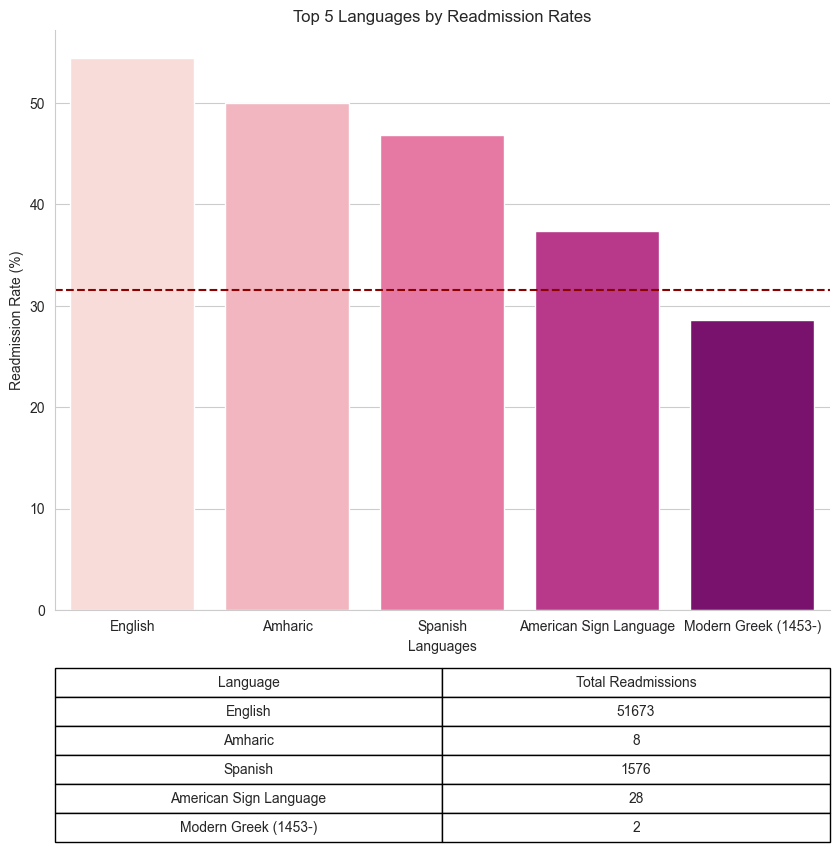

In [103]:
# Sort and take top 5 languages by readmission rates
top_languages = language_readmission_rates.sort_values(by='percent_total_readmissions', ascending=False).head(5)

fig, ax = plt.subplots(figsize=(10, 10))

# Bar plot
sns.barplot(data=top_languages, y='percent_total_readmissions', x='language', orient='v', palette='RdPu', ax=ax)

# Plot mean line
ax.axhline(y=language_readmission_rates['percent_total_readmissions'].mean(), color='darkred', linestyle='--')

# Titles and labels
ax.set_title('Top 5 Languages by Readmission Rates')
ax.set_ylabel('Readmission Rate (%)')
ax.set_xlabel('Languages')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add a table below the plot
# Format data for table
table_data = top_languages[['language', 'total_readmissions']].round(2).values

# Column labels
col_labels = ['Language', 'Total Readmissions']

# Create the table
table = plt.table(cellText=table_data,
                  colLabels=col_labels,
                  cellLoc='center',
                  loc='bottom',
                  bbox=[0.0, -0.4, 1, 0.3])  # [left, bottom, width, height]

# Adjust layout so table fits
plt.subplots_adjust(bottom=0.3)

plt.show()

- Language barriers may play a role in higher readmission rates and providing adqeuate care to patients of different backgrounds. Generally, english speakers have the highest associated readmission rate but there is also a greater pool of english speakers as well. Those speaking Spanish, the second most spoken language in the U.S. are also at greater risks of high readmission rates which could be a contributing factor as to why those identifying as latino have higher readmission rates as well. Additionally, those speaking Amharic, American Sign language have readmission rates above the overall average across languages suggesting targeted intervention is indeed needed for these language groups. 

## Marital Status and Mental Health Diagnosis

In [43]:
#1. What are readmission rates by martial status? how do readmission rates differ?
readmission_rate_by_marital_status = QUERY("""
SELECT
  marital_status,
  -- Percentage of patients with this marital status who were readmitted
  SUM(had_readmission_within_30) * 100.0 / COUNT(*) AS percent_of_readmission,

  -- Bayes' Theorem: P(marital_status | readmitted)
  ((
    (SUM(had_readmission_within_30) * 1.0 / COUNT(*)) * 28.1
  ) / (
    (SUM(had_readmission_within_30) * 1.0 / COUNT(*)) * 28.1 +
    (SUM(CASE WHEN had_readmission_within_30 = 0 THEN 1 ELSE 0 END) * 1.0 / COUNT(*)) * 71.9
  )) * 100 AS bayes_p_marital_given_readmitted
  

FROM
  `patient_info.MH-ED-READMISSIONS` AS r
LEFT JOIN 
  `patient_info.MH-PATIENT-DEMO` AS p
ON
  r.subject_id = p.subject_id
LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d

ON r.stay_id = d.stay_id
WHERE d.is_mh_disorder = 1
GROUP BY
  marital_status
ORDER BY percent_of_readmission DESC
""")

In [44]:
readmission_rate_by_marital_status

,marital_status,percent_of_readmission,bayes_p_marital_given_readmitted
0,DIVORCED,57.135187,34.250795
1,SINGLE,56.260742,33.453251
2,WIDOWED,55.436856,32.713557
3,MARRIED,27.563473,12.946179
4,None,8.021642,3.296090


All groups exhibit high rates of readmission, with the exception of patients who are married or categorized as 'None,' suggesting these individuals may be at lower risk of returning to the emergency department. In fact, using Bayes’ Theorem, we found that the probability of a patient being married given that they were readmitted is approximately 13%, further supporting the idea that married individuals are less likely to be readmitted. This reinforces the potential protective role of social support. As such, it may be beneficial to develop targeted interventions for patients with limited social support—particularly those who are unmarried or without a stable support system—to help reduce readmission rates.

In [35]:
#1.1 What are readmission rates by martial status and mental health diagnosis category?
readmission_rate_by_marital_status_and_mh_cat = QUERY("""
SELECT
  marital_status,
  mental_health_category,
  -- Percentage of patients with this marital status who were readmitted
  SUM(had_readmission_within_30) * 100.0 / COUNT(*) AS percent_of_readmission,

  -- Bayes' Theorem: P(marital_status | readmitted)
  ((
    (SUM(had_readmission_within_30) * 1.0 / COUNT(*)) * 28.1
  ) / (
    (SUM(had_readmission_within_30) * 1.0 / COUNT(*)) * 28.1 +
    (SUM(CASE WHEN had_readmission_within_30 = 0 THEN 1 ELSE 0 END) * 1.0 / COUNT(*)) * 71.9
  )) * 100 AS bayes_p_marital_given_readmitted
  

FROM
  `patient_info.MH-ED-READMISSIONS` AS r
LEFT JOIN 
  `patient_info.MH-PATIENT-DEMO` AS p
ON
  r.subject_id = p.subject_id
LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d

ON r.stay_id = d.stay_id
WHERE d.is_mh_disorder = 1
GROUP BY
  marital_status,mental_health_category
ORDER BY percent_of_readmission DESC
""")

Text(0.5, 0, 'Readmission Rate (%)')

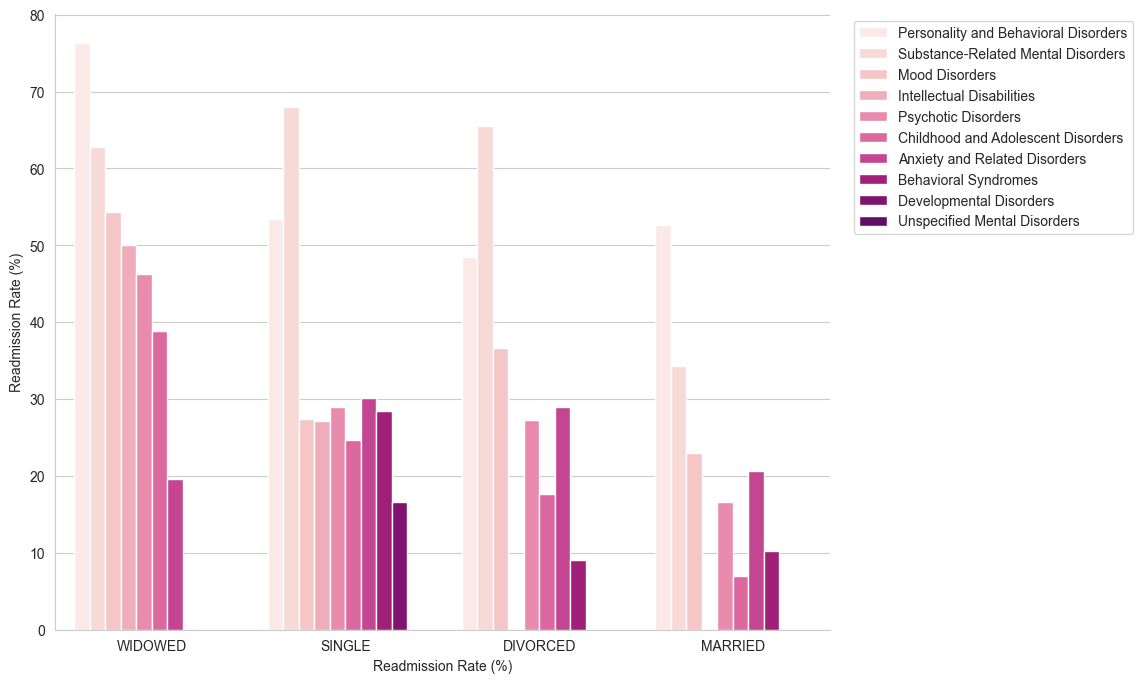

In [36]:
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(data=readmission_rate_by_marital_status_and_mh_cat,x='marital_status',y='percent_of_readmission',hue='mental_health_category',palette='RdPu',ax=ax)
ax.legend(loc='upper right',bbox_to_anchor=(1.40, 1))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Readmission Rate (%)')
ax.set_xlabel('Readmission Rate (%)')

From this data, it is clear that married individuals are a less risk of readmission for any given disorder compared to all other groups which are essentially single/ not partnered. Suggesting that being partnered acts as a protective factor. Substance Abuse and Personality and Behaviour Disorders continue to have high readmission rates across groups. Notably, Widowed individuals have significantly higher rates of readmission for those diagnosed with some Personality and Behaviour Disorder. There are is a None category under the marital status, patients that indicate this tend to have lower readmission rates like those that say they are married. So, it could be the case these patients indicate none because no option for partnered is presented. 

Social support may play a **protective role**. Notably, **married individuals and those categorized as 'None'** for marital status have the **lowest readmission rates**.

Using **Bayes’ Theorem**, we found that the **probability of being married given readmission is only 13%**, reinforcing the idea that **social support systems may reduce the risk of ED return**.

This finding supports the implementation of **interventions that target socially isolated individuals** to improve mental health outcomes.


## Insurance and Readmission Rates

In [83]:
#1. What are the insurance provider by readmission rates?
insurance_readmission_rates = QUERY("""
SELECT  
  insurance,
  SUM(had_readmission_within_30) AS total_readmissions,
  ROUND((SUM(had_readmission_within_30)/COUNT(*))*100,2) AS percent_total_readmissions
FROM 
  `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r
  
LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS p
ON
r.subject_id = p.subject_id

LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d

ON r.stay_id = d.stay_id
WHERE d.is_mh_disorder = 1 
GROUP BY insurance
ORDER BY percent_total_readmissions DESC
""")

In [84]:
insurance_readmission_rates

,insurance,total_readmissions,percent_total_readmissions
0,Other,3752,60.01
1,Medicaid,24529,56.61
2,No charge,97,54.49
3,Medicare,11230,53.99
4,None,7815,40.54
5,Private,6188,38.03


Those that list they have private insurance or none, have the lowest readmission rate compared to all other groups which have readmission rates above the overall readmission rates of those admitted for some mental health disorder

In [104]:
#1.1 Readmission rates by insurance provider and race with readmission rates greater than 50%?
insurance_and_race_readmission_rates = QUERY("""
SELECT  
  mental_health_category,
  insurance,
  SUM(had_readmission_within_30) AS total_readmissions,
  ROUND((SUM(had_readmission_within_30)/COUNT(*))*100,2) AS percent_total_readmissions
FROM 
  `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r
  
LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS p
ON
r.subject_id = p.subject_id
LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d
ON r.stay_id = d.stay_id
WHERE d.is_mh_disorder = 1 AND mental_health_category = 'Substance-Related Mental Disorders'
GROUP BY mental_health_category,insurance
HAVING
    percent_total_readmissions > 40
ORDER BY percent_total_readmissions DESC

""")

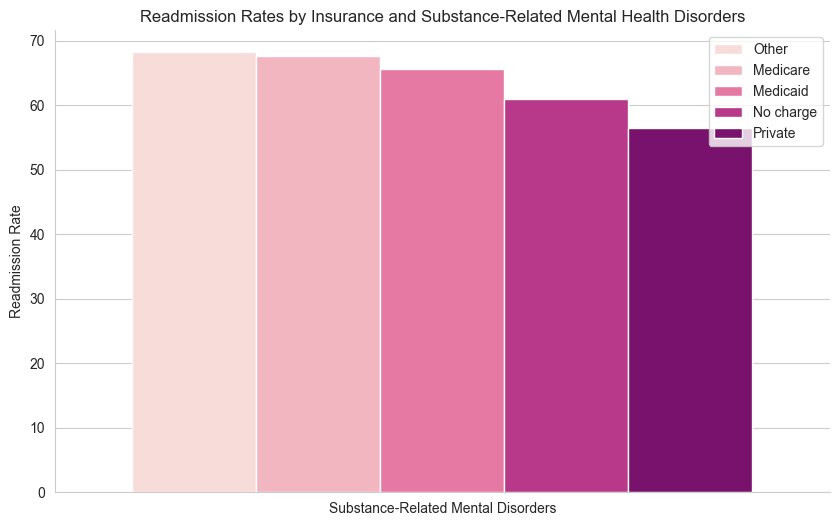

In [108]:
fig,ax = plt.subplots(figsize=(10,6))
sns.barplot(data=insurance_and_race_readmission_rates, x="mental_health_category", y="percent_total_readmissions",hue="insurance",palette='RdPu')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Readmission Rate')
ax.set_xlabel('')
ax.set_title('Readmission Rates by Insurance and Substance-Related Mental Health Disorders')
ax.legend()

- Those with private insurance had the lowest readmission rate for individuals diagnosed with some substance related disorder. This may indicate that individuals with private insurance have greater access to resources and more wealth.

## Substance Related Mental Health Disorders and Medicaitions

In [31]:
#1. Medications patients were taking and Substance Related Mental Health Disorders by readmission rate
readmission_rate_by_med_and_substance_disorder = QUERY("""
SELECT  
  CASE
    WHEN mental_health_category = "Substance-Related Mental Disorders" THEN 1
    ELSE 0
  END AS substance_related_disorder,
  m.name AS med_name,
  SUM(had_readmission_within_30) AS total_readmissions,
  ROUND((SUM(had_readmission_within_30)/COUNT(*))*100,2) AS percent_total_readmissions
FROM 
  `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r
  
LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS p
ON
r.subject_id = p.subject_id
LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d
ON r.stay_id = d.stay_id
LEFT JOIN 
    `physionet-data.mimiciv_ed.medrecon` AS m
ON  
    r.stay_id = m.stay_id
WHERE d.is_mh_disorder = 1

GROUP BY substance_related_disorder,med_name
HAVING
     percent_total_readmissions > 50 AND total_readmissions > 50
ORDER BY percent_total_readmissions DESC
""")

In [32]:
readmission_rate_by_med_and_substance_disorder

,substance_related_disorder,med_name,total_readmissions,percent_total_readmissions
0,1,Chlordiazepoxide HCl,90,100.00
1,0,Omega 3,60,100.00
2,0,fosamprenavir,78,100.00
3,0,methenamine hippurate,200,99.01
4,1,multivitamin [Multiple Vitamin Essential],148,98.67
...,...,...,...,...
148,1,Bayer Aspirin,92,50.55
149,1,hydrocortisone,89,50.28
150,1,levetiracetam [Keppra],104,50.24
151,1,One Daily Multivitamin,221,50.11


There are various medications associated with higher admission rates and very total readmission sizes but it seems to be that those that were taking Chlordiazepoxide HCl, Omega 3, or fosamprenavir prior to admission had a 100% readmission rate which may be the result of other factors but nonetheless something is contributing to their 100% readmission rate and it bares further investigation.

# Emergency Department Readmissions for Mental Health: Key Findings and Implications

## 1. Mental Health vs. Non-Mental Health Readmissions  
**Key Finding:**  
Approximately 50% of ED admissions for mental health issues were readmissions, more than double the rate for non-mental health-related admissions (~23%).

**Recommendation:**  
TBD



## 2. Readmissions by Age Group  
**Key Findings:**  
- Age groups 50–59 (72%) and 40–49 (53%) have the highest readmission rates.  
- Contrary to expectations, patients 80+ have lower readmission rates, suggesting age alone is not the primary driver.

**Recommendation:**  
TBD



## 3. Readmissions by Age and Diagnosis  
**Key Findings:**  
- Substance-related and personality disorders show consistently high readmission rates across all age groups.  
- Patients in their 50s with substance-related diagnoses have a 78% readmission rate—the highest in any age-diagnosis pair.  

**Other Highlights:**  
- **20s**: Intellectual disabilities show highest rates.  
- **60s**: Developmental disorders (50%).  
- **90s+**: Psychotic disorders (41%).

**Recommendation:**  
TBD



## 4. Comorbidities and Complexity by Age  
**Key Finding:**  
Patients aged 40–59 have the highest average number of comorbidities, suggesting greater complexity and likely contributing to higher readmission rates.

**Recommendation:**  
TBD



## 5. Gender Differences in Readmissions  
**Key Finding:**  
59.12% of male ED admissions are readmissions vs. lower in females. This may be linked to the prevalence of substance-related mental health disorders in males.

**Recommendation:**  
TBD



## 6. Readmissions by Gender and Diagnosis  
**Key Findings:**  

**Males:**  
- 67% of admissions for substance-related disorders were readmissions.  
- 53% for personality disorders.  

**Females:**  
- 55% of personality disorder admissions were readmissions.  
- 29% for substance-related disorders.

**Recommendation:**  
TBD



## 7. Top ICD Diagnoses Driving Readmissions  
**Key Finding:**  
Substance-related, personality/behavioral, mood (especially depressive disorder), and anxiety disorders are consistently among the top contributors to readmissions.

**Recommendation:**  
TBD



## 8. Readmissions by Race and Ethnicity  
**Key Finding:**  
High readmission risk is concentrated in the following groups:
- Black/African American  
- Hispanic/Latino (Cuban, Puerto Rican, Honduran)  
- Portuguese  
- American Indian/Alaska Native  
- Unknown

**Recommendation:**  
TBD



## 9. Readmissions by Language  
**Key Finding:**  
- English speakers have the highest volume and rate.  
- Spanish, Amharic, and American Sign Language speakers have above-average readmission rates, suggesting potential barriers in culturally or linguistically tailored care.

**Recommendation:**  
TBD



## 10. Readmissions by Marital Status  
**Key Findings:**  
- Married and “None” (possibly unlisted “partnered”) statuses show lowest readmission rates.  
- Widowed individuals are at particularly high risk with certain diagnoses.  

**Bayesian Insight:**  
The probability of being married given readmission is only 13%—indicating protective social support.

**Recommendation:**  
TBD



## 11. Readmissions by Insurance Type  
**Key Finding:**  
Patients with private insurance or no insurance had the lowest readmission rates, particularly for substance-related disorders—potentially due to resource access and wealth disparity.

**Recommendation:**  
TBD



## 12. Medications with 100% Readmission Rate  
**Key Finding:**  
Chlordiazepoxide HCl, Omega-3, and Fosamprenavir had 100% readmission rates in the dataset. These require further investigation to determine causality or correlation.

**Recommendation:**  
TBD

## Next Steps: Predictive Modeling for Targeted Care

Given the consistent impact of **Substance-Related Mental Health Disorders** on readmission across age, sex, and racial groups, the next step involves the development of a **machine learning model** to **predict individual risk of ED readmission** for these diagnoses.

Such a model could empower healthcare providers to:
- Identify high-risk patients at the point of discharge
- Prioritize care plans
- Tailor follow-up strategies
- Ultimately, **reduce avoidable readmissions** and improve patient outcomes

**Variables identified to be associaited with higher admission rates for substance abuse related disorders:**
- Unmarried individuals, feature engineer a binary variable, married vs unmarried
- Black/African Patiants, feature engineer a binary variable, Black/African?
- American Indian/Alaska Native Patiants, feature engineer a binary variable, American Indian/Alaska Native?	
- PORTUGUESE Patiants, feature engineer a binary variable, PORTUGUESE?
- Cuban Patiants, feature engineer a binary variable, Cuban?
- BLACK/AFRICAN AMERICAN Patiants, feature engineer a binary variable, BLACK/AFRICAN AMERICAN?
- Puerto Rican Patiants, feature engineer a binary variable, Puerto Rican?
- Unknown Patiants, feature engineer a binary variable, Unknown?
- Hispanic or Latino Patiants, feature engineer a binary variable, Hispanic or Latino?
- WHITE Patiants, feature engineer a binary variable, WHITE?
- Other Patiants, feature engineer a binary variable, Other?
- Male Patients, feature engineer a binary variable
- Patients 50 - 59
- Patients 40 - 49
- Num of Comorbitites
- Varios medications (Create medication frequiences accounting for medications not listed by setting the default to 0)